このコードは、「Pythonと複雑ネットワーク分析」に記載されたコードを参照しています

graph-toolをインポート

In [1]:
import graph_tool.all as gt

空のグラフを作成

In [2]:
g = gt.Graph()

デフォルトでは有向グラフが生成される

とりあえずノードを2つグラフに追加する

In [3]:
v1 = g.add_vertex()
v2 = g.add_vertex()

v1からv2へリンクを張る

In [4]:
e = g.add_edge(v1, v2)

グラフを描画する

（ノード番号を18pのフォントサイズで付加する）

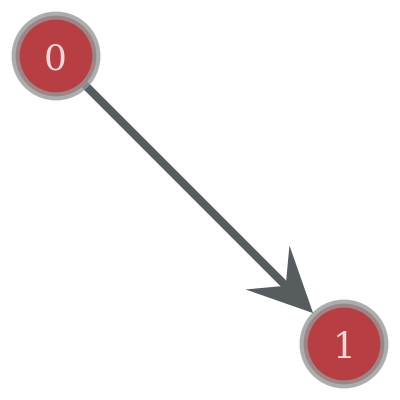

In [5]:
gt.graph_draw(g, vertex_text = g.vertex_index, vertex_font_size = 18, output_size=(200, 200));

10 * 20の2次元正方格子に周期境界条件を課したネットワークを生成する

※pos：描画時のノードの位置を指定するパラメータ、今回はできるだけ均等にノードが拡がって描画するようにした

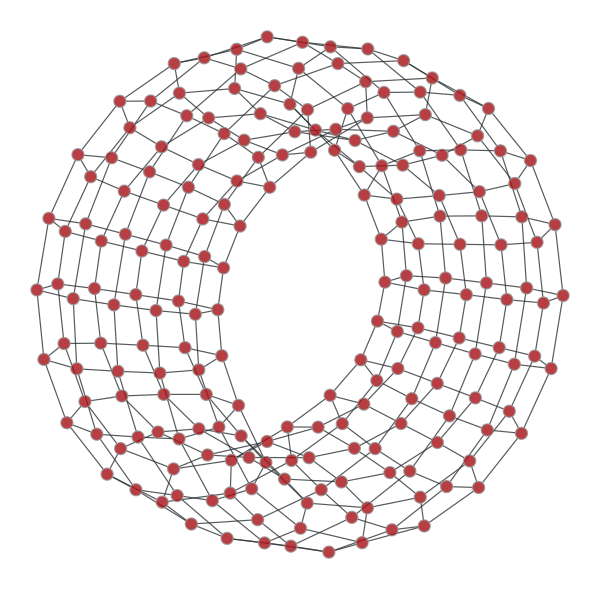

In [6]:
g = gt.lattice([10, 20], periodic = True)
pos = gt.sfdp_layout(g, cooling_step = 0.95, epsilon = 1e-2)
gt.graph_draw(g, pos = pos, output_size = (300, 300));

ノード数20の完全グラフを生成、描画

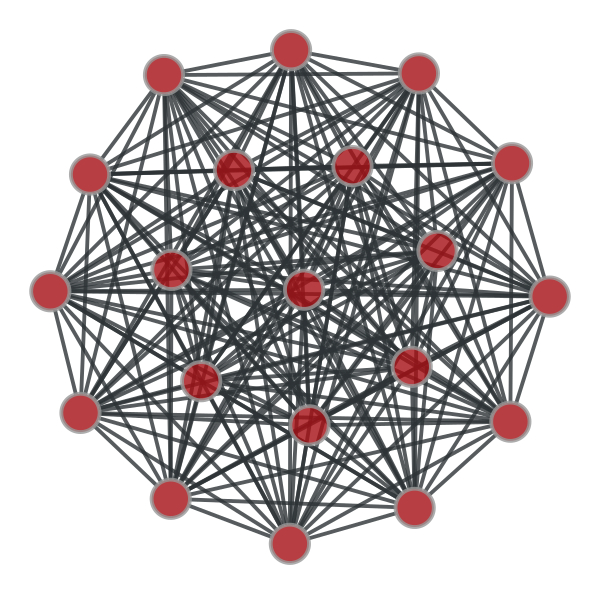

In [7]:
g = gt.complete_graph(20)
pos = gt.sfdp_layout(g, cooling_step = 0.95, epsilon=1e-2)
gt.graph_draw(g, pos = pos, output_size = (300, 300));

ノード数20、最近接ノード数4の円形格子を描画

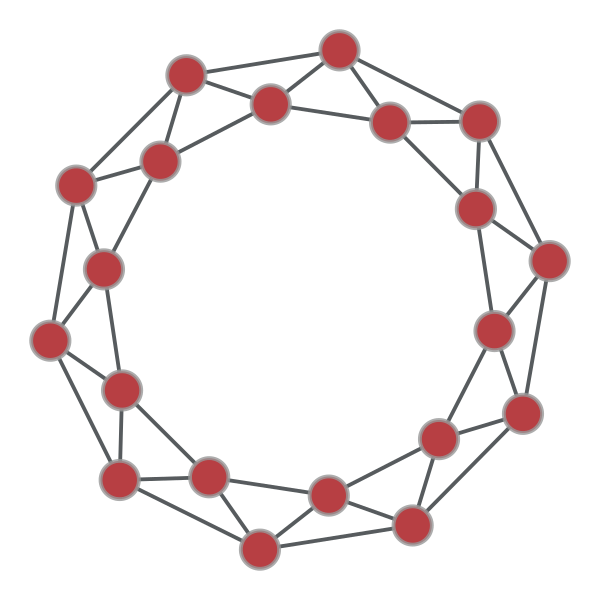

In [8]:
g = gt.circular_graph(20, 2)
pos = gt.sfdp_layout(g, cooling_step = 0.95, epsilon=1e-2)
gt.graph_draw(g, pos = pos, output_size = (300, 300));

numpyの種々の乱数生成ルーチンをインポート

In [6]:
import numpy.random as rnd

ノード数n、接続隣接ノード数2kの円形格子を作成、そこから与えた確率pで円形格子のリンクの接続先をランダムに選んで繋ぎ変える

In [7]:
def ws_graph(n, k, p):
    #基本となる円形格子を生成
    base_g = gt.circular_graph(n, k)
    
    #p = 0、リンクの張替えをしない場合は、そのまま円形格子を返却する
    if p == 0:
        return base_g
    
    #リンクの張替えがあり得る場合、空の無向グラフ(directed = False)を生成し、n個のノード数を付け加える
    g = gt.Graph(directed = False)
    g.add_vertex(n)
    #張替え前のbase_gのすべてのリンクを走査し、生成乱数がpより少なければ、リンクの張替えを行う
    #ただし、複数リンク・自己ループとならないようにする
    for edg in base_g.edges():
        st_vtx = edg.source()
        tg_vtx = edg.target()
        if rnd.random() < p:
            #新しいリンク先の候補を生成
            nw_tg_idx = rnd.choice(n)
            nw_tg_vtx = base_g.vertex(nw_tg_idx)
            while ((nw_tg_vtx in st_vtx.all_neighbors())
            or nw_tg_vtx == st_vtx):
                #もし、新しいリンク先によって複数リンク・自己ループになる場合、別のリンク先を新たに探す
                nw_tg_idx = rnd.choice(n)
                nw_tg_vtx = base_g.vertex(nw_tg_idx)
            if g.edge(st_vtx, nw_tg_vtx) == None:
                #以前のリンク張替えによって、張ろうとするリンクがすでにある場合をのぞき、リンクの張替えを行う
                g.add_edge(st_vtx, nw_tg_vtx)
        else:
            if g.edge(st_vtx, tg_vtx) == None:
                g.add_edge(st_vtx, tg_vtx)
    return g

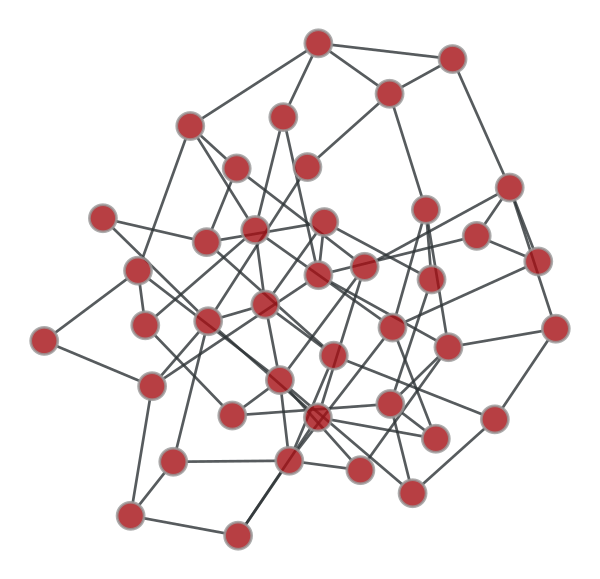

In [8]:
ws_g = ws_graph(40, 2,0.99)
pos = gt.sfdp_layout(ws_g, cooling_step = 0.95, epsilon=1e-2)
gt.graph_draw(ws_g, pos = pos, output_size = (300, 300));

あるネットワーク内における「平均最短経路長」を求める関数を作成

In [9]:
def avr_distance(g):
    return np.mean([np.mean(dist_itm) for dist_itm in gt.shortest_distance(g)])

ノード数1000、接続隣接ノード数10の円形格子から始め、リンク張替えの確率pを0から1まで変えながら、

ネットワーク内のクラスタ係数と平均最短経路長を計測することを20回繰り返し、

その結果を平均して最終結果として返還してみる

In [10]:
import numpy as np

In [11]:
#基本となる円形格子の生成
base_g = ws_graph(1000, 5, 0)
#クラスタ係数と平均最短経路長を計算する
clst_coeff0 = gt.global_clustering(base_g)[0]
avr_dist0 = avr_distance(base_g)

#リンク張替えの確率のリストを生成
#0.0001から1まで対数プロットで均等となる15点を生成する
p_list = np.logspace(-4, 0, num = 15)

#サンプル数は20
sample = 20
#結果を入れるリストを初期化
clst_coeff_list = []
avr_dist_list = []

#20回、各pについて、クラスタ係数と平均最短経路長の計測を行う
for i in range(sample):
    clst_coeff = []
    avr_dist = []
    for p in p_list:
        ws_g = ws_graph(1000, 5, p)
        clst_coeff.append(gt.global_clustering(ws_g)[0]/clst_coeff0)
        avr_dist.append(avr_distance(ws_g)/avr_dist0)
    clst_coeff_list.append(clst_coeff)
    avr_dist_list.append(avr_dist)
    
#20回のサンプルについて平均を計算し、最終結果とする
clst_coeff_mean = np.mean(clst_coeff_list, axis = 0)
avr_dist_mean = np.mean(avr_dist_list, axis = 0)

得られた結果をmatolotlibを用いて片対数プロットする

In [12]:
import matplotlib.pyplot as plt

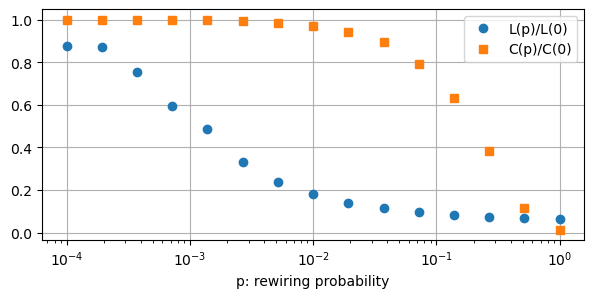

In [13]:
plt.figure(figsize = (7, 3))
plt.semilogx(p_list, avr_dist_mean, 'o', label = "L(p)/L(0)")
plt.semilogx(p_list, clst_coeff_mean, 's', label = "C(p)/C(0)")
plt.xlabel('p: rewiring probability')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

次数kをもつネットワークの次数を与えられた次数分布に従って生成する関数

In [17]:
def sample_k(kmin, kmax):
    accept = False
    while not accept:
        k = rnd.randint(kmin, kmax + 1)
        if rnd.random() < k**(-lmbd):
            accept = True
    return k

ノード数N、ベキ指数λをもつSFネットワークの最大次数を決める

In [18]:
def max_degree(k_min, total_node, lmbd):
    return int(k_min * total_node ** (1 / (lmbd - 1)))

In [19]:
total_nodes = 10000
lmbd = 2.5
kmin = 2

In [20]:
kmax = max_degree(kmin, total_nodes, lmbd)
kmax

928

上記の情報を基に、SFネットワークを作成する

In [21]:
g = gt.random_graph(total_nodes, lambda: sample_k(kmin, kmax), directed = False)

ネットワークの次数分布を確認してみる

In [22]:
deg_hist = gt.vertex_hist(g, "out")

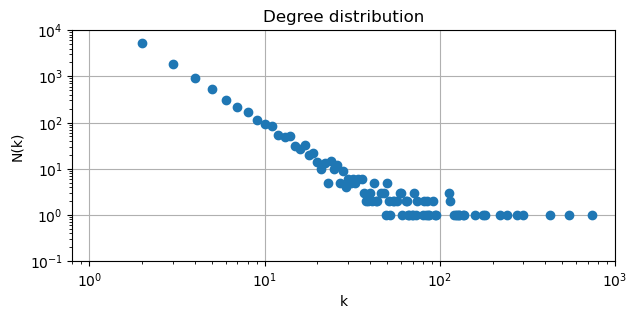

In [23]:
plt.figure(figsize =(7, 3))
plt.loglog(deg_hist[0], 'o')
plt.ylim(1e-1, 1e4)
plt.xlim(0.8, 1e3)
plt.grid(True)
plt.title("Degree distribution")
plt.xlabel("k")
plt.ylabel("N(k)")
plt.show()

SFネットワークの全てのノードを次数の大きい順に並べ替えたリストを生成し、そのリストによりノード除去を行い、

最大連結成分を計算する

In [24]:
vertices = sorted([v for v in g.vertices()], key=lambda v:v.out_degree())
sizes, comp = gt.vertex_percolation(g, vertices)

ノードリストをランダムに並べ替え、そのリストによりノード除去を行い、最大連結成分を計算

In [25]:
rnd.shuffle(vertices)
sizes2, comp = gt.vertex_percolation(g, vertices)

除去後に残ったノード数の除去前のノード数に対する割合と、

除去後の最大連結成分の除去前の全ノード数に対する割合を計算し、プロットする

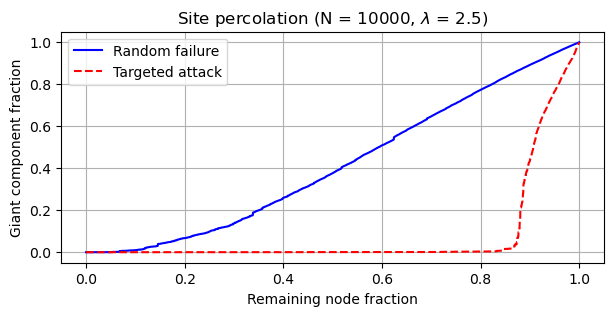

In [26]:
rem_nd_frac = [nd / total_nodes for nd in range(total_nodes)]
rnd_perc = [frc / total_nodes for frc in sizes2]
trg_perc = [frc / total_nodes for frc in sizes]

plt.figure(figsize =(7, 3))
plt.plot(rem_nd_frac, rnd_perc, 'b-', label = "Random failure")
plt.plot(rem_nd_frac, trg_perc, 'r--', label = "Targeted attack")
plt.grid(True)
plt.title("Site percolation (N = 10000, $\lambda$ = 2.5)")
plt.xlabel("Remaining node fraction")
plt.ylabel("Giant component fraction")
plt.legend(loc = "upper left")
plt.show()

総ノード数10000、最小次数2、最大次数100、べき指数2.5の次数相関を持たないSFネットワークを生成

In [27]:
g = gt.random_graph(total_nodes, lambda:sample_k(2, 100), directed = False)

次数相関係数を計算する

In [28]:
gt.scalar_assortativity(g, "out")

(-0.004602828470931247, 0.00754654896313997)

In [29]:
a = 5.0

先ほどのSFネットワークに正の次数相関を導入する。

「random_graph」によるネットワーク生成の際に、「model」および「edge-probe」を追加指定することで、

2本のリンクをランダムに選択し、「edge-probe」で指定した結合確率に従うようにリンクの張替えを行ってくれる

「model="probabilistic-configuration"」で、次数分布は変わらないようにリンクの張替えを行うことを指定する

「n_iter = 20」で、全リンクの走査を20ラウンド行って、各リンクを20回張り替えることで、ノード間の結合確率が統計的に指定されたものに

近くなるようにする

In [30]:
g_5 = gt.random_graph(total_nodes, lambda:sample_k(2, 100), directed = False, model = "probabilistic-configuration",
                      n_iter = 20, edge_probs = lambda i, k: 1.0/(1 + a * np.abs(i - k)))

In [31]:
gt.scalar_assortativity(g_5, "out")

(0.6537147106719754, 0.010412332289895127)

In [32]:
vertices = sorted([v for v in g.vertices()], key = lambda v:v.out_degree())

sizes_tg, comp = gt.vertex_percolation(g, vertices)
rnd.shuffle(vertices)
sizes, comp = gt.vertex_percolation(g, vertices)

In [33]:
vertices_5 = sorted([v for v in g_5.vertices()], key = lambda v:v.out_degree())

sizes_5_tg, comp = gt.vertex_percolation(g_5, vertices_5)
rnd.shuffle(vertices_5)
sizes_5, comp = gt.vertex_percolation(g_5, vertices_5)

In [34]:
rem_nd_frac = [nd/total_nodes for nd in range(total_nodes)]
nd_perc_0_rnd = [frc/total_nodes for frc in sizes]
nd_perc_5_rnd = [frc/total_nodes for frc in sizes_5]
nd_perc_0_trg = [frc/total_nodes for frc in sizes_tg]
nd_perc_5_trg = [frc/total_nodes for frc in sizes_5_tg]

<function matplotlib.pyplot.show(close=None, block=None)>

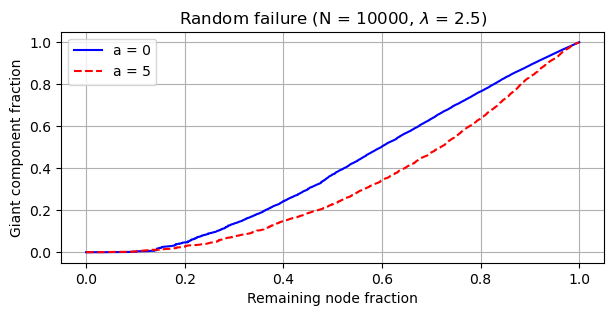

In [35]:
plt.figure( figsize=(7, 3) )
plt.plot(rem_nd_frac, nd_perc_0_rnd, 'b-', label = "a = 0")
plt.plot(rem_nd_frac, nd_perc_5_rnd, 'r--', label = "a = 5")
plt.xlabel("Remaining node fraction")
plt.ylabel("Giant component fraction")
plt.title("Random failure (N = 10000, $\lambda$ = 2.5)")
plt.grid(True)
plt.legend(loc = "upper left")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

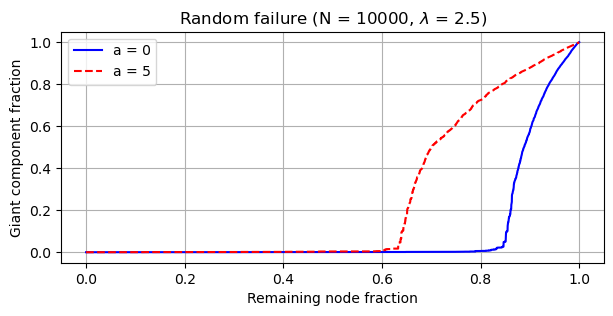

In [36]:
plt.figure( figsize=(7, 3) )
plt.plot(rem_nd_frac, nd_perc_0_trg, 'b-', label = "a = 0")
plt.plot(rem_nd_frac, nd_perc_5_trg, 'r--', label = "a = 5")
plt.xlabel("Remaining node fraction")
plt.ylabel("Giant component fraction")
plt.title("Random failure (N = 10000, $\lambda$ = 2.5)")
plt.grid(True)
plt.legend(loc = "upper left")
plt.show

In [37]:
g = gt.collection.data["netscience"]
g = gt.GraphView(g, vfilt = gt.label_largest_component(g), directed = False)
g = gt.Graph(g, prune = True)

In [38]:
(g.num_vertices(), g.num_edges())

(379, 914)

In [39]:
S = 0
I = 1
R = -1

In [40]:
state = g.new_vertex_property("int")

In [41]:
x = 0.001
r = 0.1
s = 0.01

In [42]:
def update_state():
    #全ノードをランダムに並べ替える
    vs = list(g.vertices())
    rnd.shuffle(vs)
    #並べ替えたノードリストを走査し状態更新を行う
    for v in vs:
        if state[v] == I:
            if rnd.random() < r:
                state[v] = R
        elif state[v] == S:
            if rnd.random() < x:
                state[v] = I
                
            else:
                ns = list(v.out_neighbors())
                if len(ns) > 0:
                    w = ns[rnd.randint(0, len(ns))]
                    if state[w] == I:
                        state[v] = I
        elif rnd.random() < s:
            state[v] = S
    return

In [44]:
for v in g.vertices():
    state[v] = S
    
max_itr = 1000

suscept_st = []
infect_st = []
recov_st = []

for updt in range(max_itr):
    update_state()
    suscept_st.append(list(state.a).count(S) / g.num_vertices())
    infect_st.append(list(state.a).count(I) / g.num_vertices())
    recov_st.append(list(state.a).count(R) / g.num_vertices())

<function matplotlib.pyplot.show(close=None, block=None)>

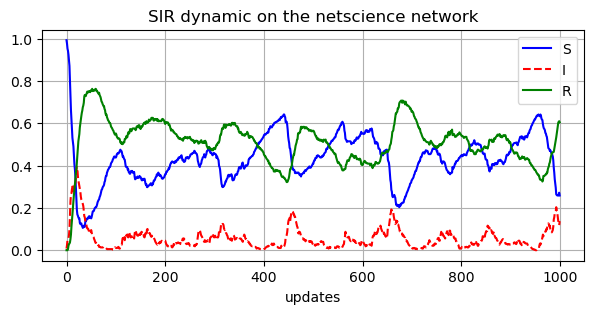

In [45]:
plt.figure( figsize=(7, 3) )
plt.plot(suscept_st, 'b-', label = "S")
plt.plot(infect_st, 'r--', label = "I")
plt.plot(recov_st, 'g-', label = "R")
plt.title("SIR dynamic on the netscience network")
plt.grid(True)
plt.legend(loc = "upper right")
plt.xlabel("updates")
plt.show